## Data Preprocessing


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.3 MB/s eta 0:00:00


In [ ]:
import os
import hashlib

def file_hash(filepath):
    """Generate hash for a file to identify duplicates."""
    hash_obj = hashlib.md5()  # Using MD5 for simplicity
    with open(filepath, 'rb') as f:
        # Read the file in chunks to avoid memory issues with large files
        for chunk in iter(lambda: f.read(4096), b""):
            hash_obj.update(chunk)
    return hash_obj.hexdigest()

def remove_duplicates(directory):
    """Remove duplicate files in the specified directory."""
    hashes = {}  # Dictionary to store file hashes
    duplicate_count = 0

    for root, _, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            filehash = file_hash(filepath)

            if filehash in hashes:
                # Duplicate file found, remove it
                print(f"Removing duplicate file: {filepath}")
                os.remove(filepath)
                duplicate_count += 1
            else:
                # Store the hash and filepath
                hashes[filehash] = filepath

    print(f"Total duplicates removed: {duplicate_count}")


In [ ]:
patient_folders_path = '/content/drive/MyDrive/siddhi2.0/Patients_CT'


for patient in os.listdir(patient_folders_path):
  directory_path = os.path.join(patient_folders_path , patient)
  brain_path = os.path.join(directory_path , "brain")
  bone_path = os.path.join(directory_path , "bone")
  remove_duplicates(brain_path)
  remove_duplicates(bone_path)

Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Removing duplicate file: /content/drive/MyDrive/siddhi2.0/Patients_CT/050/brain/10.jpg
Removing duplicate file: /content/drive/MyDrive/siddhi2.0/Patients_CT/050/brain/11.jpg
Removing duplicate file: /content/drive/MyDrive/siddhi2.0/Patients_CT/050/brain/15.jpg
Removing duplicate file: /content/drive/MyDrive/siddhi2.0/Patients_CT/050/brain/13.jpg
Removing duplicate file: /content/drive/MyDrive/siddhi2.0/Patients_CT/050/brain/12.jpg
Removing duplicate file: /content/drive/MyDrive/siddhi2.0/Patients_CT/050/brain/14.jpg
Removing duplicate file: /content/drive/MyDrive/siddhi2.0/Patients_CT/050/brain/16.jpg
Total duplicates removed: 7
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0
Total duplicates removed: 0

In [ ]:
import os

In [ ]:
path_dir = r"/content/drive/MyDrive/siddhi2.0/Patients_CT";
for patient in os.listdir(path_dir):
  path_patient = os.path.join(path_dir , str(patient))
  path_patient_brain = os.path.join(path_patient , "brain")
  path_patient_bone = os.path.join(path_patient , "bone")

  for filename in os.listdir(path_patient_brain):
    if "_HGE_Seg" in filename:
      file_path = os.path.join(path_patient_brain , str(filename))
      if os.path.isfile(file_path):
        os.remove(file_path)

  for filename in os.listdir(path_patient_bone):
    if "_HGE_Seg" in filename:
      file_path = os.path.join(path_patient_bone , str(filename))
      if os.path.isfile(file_path):
        os.remove(file_path)




# Defining functions


In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.losses import binary_crossentropy
import os

In [ ]:
def data_generator(patient_folders_path, labels, batch_size , epochs):
    patient_ids = labels['PatientNumber'].unique()
    num_patients = len(patient_ids)

    for i in range(epochs):
        for offset in range(0, num_patients, batch_size):
          batch_patients = patient_ids[offset:offset + batch_size]

          X_batch = []
          y_batch = []

          for patient_no in batch_patients:
            path = os.path.join(patient_folders_path , f"{patient_no:03}")
            slice_imgs = []
            slice_labels = []
            if os.path.exists(path):
              brain_path = os.path.join(path , "brain")
              for f in sorted(os.listdir(brain_path)):
                img_path = os.path.join(brain_path , str(f))
                img = cv2.imread(img_path)
                # print(img.shape)
                slice_imgs.append(img)
                slice_no = str(f)
                sliceNo = int(slice_no.replace(".jpg" , ""))
                # print(patient_no)
                # print(sliceNo)
                label = labels[labels["PatientNumber"] == patient_no]
                slice_label = label[label["SliceNumber"] == sliceNo]
                slice_label_t = slice_label[["Intraventricular" , "Intraparenchymal" , "Subarachnoid" , "Epidural" , "Subdural" , "No_Hemorrhage"]].values.flatten()
                slice_label_t.reshape(6,1)
                slice_labels.append(slice_label_t)

            slice_labels = np.array(slice_labels)
            slice_imgs = np.array(slice_imgs)
            # print(slice_labels.shape)
            # print(slice_imgs.shape)
            X_batch = (slice_imgs)
            y_batch = (slice_labels)


          X_batch = np.array(X_batch)
          y_batch = np.array(y_batch)
          # print(X_batch.shape)
          # print(y_batch.shape)
          yield X_batch , y_batch

          # print(X_batch.shape)
          # print(y_batch)
          # print(y_batch.shape)

In [ ]:
def build_model():
  resnet_model = Sequential()

  pretrained_model= tf.keras.applications.ResNet101(include_top=False,
                    input_shape=(650 , 650 , 3),
                    pooling='avg',classes=6,
                    weights='imagenet')
  for layer in pretrained_model.layers:
          layer.trainable=False

  resnet_model.add(pretrained_model)
  resnet_model.add(Flatten())
  resnet_model.add(Dense(650, activation='relu'))
  resnet_model.add(Dense(6, activation='sigmoid'))

  return resnet_model


In [ ]:
x = load_jpg_images(r"/content/drive/MyDrive/siddhi2.0/Patients_CT/049")
print(x.shape)

(33, 512, 512, 1)


In [ ]:
# Main function
# Load labels
labels_file_path = '/content/drive/MyDrive/siddhi2.0/hemorrhage_diagnosis.csv'
labels = pd.read_csv(labels_file_path)

# Data paths and constants
patient_folders_path = '/content/drive/MyDrive/siddhi2.0/Patients_CT'  # Folder containing subfolders for each patient
batch_size = 1  # Number of patients to process per batch
epochs = 5


# Split the labels into training and validation sets
patients_train, patients_val = train_test_split(labels['PatientNumber'].unique(), test_size=0.2, random_state=42)
# print(patients_train)
# print(patients_val)
labels_train = labels[labels['PatientNumber'].isin(patients_train)]
labels_val = labels[labels['PatientNumber'].isin(patients_val)]
steps_per_epoch = len(patients_train) // batch_size

# print(labels_train)
# print(labels_val)

# Build the model
resnet_model = build_model()

# Train the model using the data generator
train_generator = data_generator(patient_folders_path, labels_train, batch_size , epochs)
val_generator = data_generator(patient_folders_path, labels_val, batch_size , epochs)

resnet_model.compile(optimizer=Adam(learning_rate=0.01),loss=binary_crossentropy,metrics=['accuracy'])


history = resnet_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(labels_val) // batch_size
)





171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/5
65/65 [==============================] - ETA: 0s - loss: 1.2357 - accuracy: 0.8515

65/65 [==============================] - 1186s 18s/step - loss: 1.2357 - accuracy: 0.8515 - val_loss: 1.9410 - val_accuracy: 0.8350
Epoch 2/5
65/65 [==============================] - 439s 7s/step - loss: 0.3473 - accuracy: 0.8555
Epoch 3/5
65/65 [==============================] - 439s 7s/step - loss: 0.2254 - accuracy: 0.8726
Epoch 4/5
65/65 [==============================] - 440s 7s/step - loss: 0.2593 - accuracy: 0.8817
Epoch 5/5
65/65 [==============================] - 442s 7s/step - loss: 0.1410 - accuracy: 0.8882


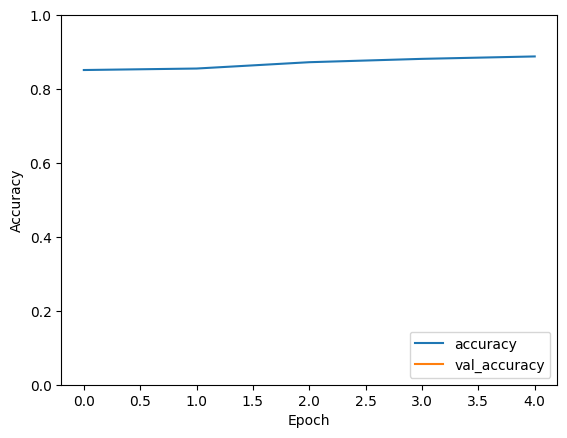

In [ ]:
resnet_model.save(r"/content/drive/MyDrive/siddhi2.0/Resnet-101-brain")
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Testing


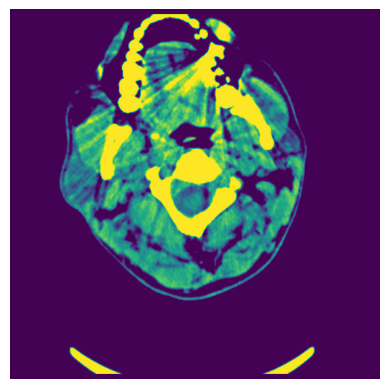

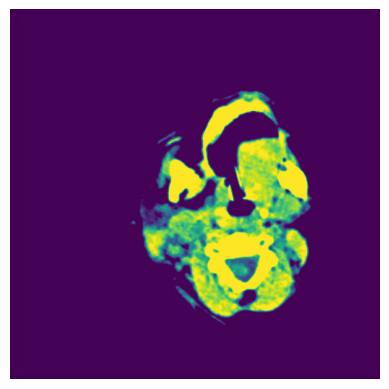

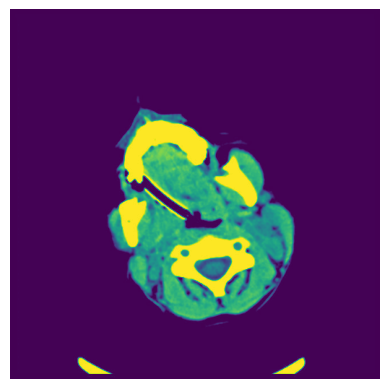

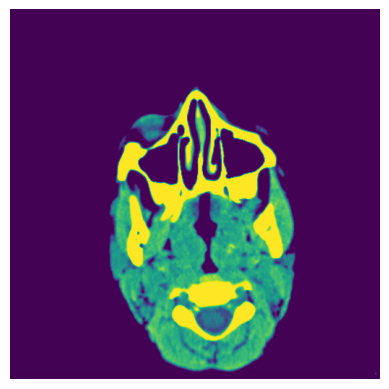

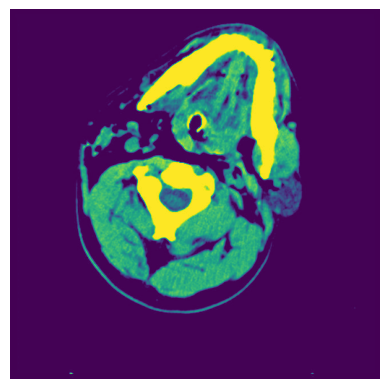

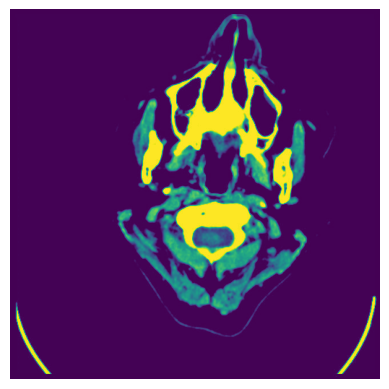

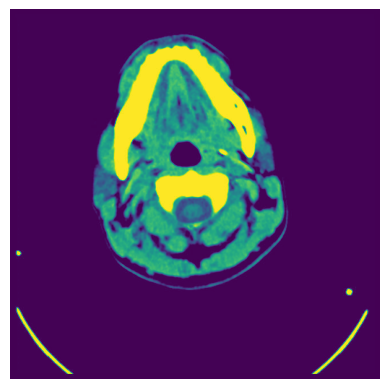

In [ ]:
patient_folders_path = '/content/drive/MyDrive/siddhi2.0/Patients_CT'
labels_file_path = '/content/drive/MyDrive/siddhi2.0/hemorrhage_diagnosis.csv'

labels = load_labels(labels_file_path)
labels = labels[:183]

patient_ids = labels['PatientNumber'].unique()
num_patients = len(patient_ids)

for offset in range(0, num_patients, 5):
    batch_patients = patient_ids[offset:offset + 5]

    X_batch = []
    y_batch = []

    for patient in batch_patients:
        patient_folder = os.path.join(patient_folders_path, f"{patient:03}")

        if os.path.exists(patient_folder):
            images = load_jpg_images(patient_folder)
            patient_labels = labels[labels['PatientNumber'] == patient]
            X_batch.extend(images)
            plt.imshow(images[0])
            plt.axis('off')  # Turn off the axis
            plt.show()
            # Combine hemorrhage columns into a single categorical label per slice
            for _, row in patient_labels.iterrows():
                slice_labels = row[['Intraventricular', 'Intraparenchymal', 'Subarachnoid', 'Epidural', 'Subdural', 'No_Hemorrhage']].values
                y_batch.append(slice_labels)

    X_batch = preprocess_images(np.array(X_batch))
    # y_batch = to_categorical(np.array(y_batch), num_classes=6)


In [ ]:
y_batch = np.array(y_batch)
print(y_batch.shape)
print(X_batch.shape)
print(y_batch)

(29, 6)
(60, 512, 512, 1)
[[0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]


In [ ]:
# def data_generator(patient_folders_path, labels, batch_size):
    patient_ids = labels['PatientNumber'].unique()
    num_patients = len(patient_ids)

    while True:  # Loop forever so the generator never terminates
        for offset in range(0, num_patients, batch_size):
            batch_patients = patient_ids[offset:offset + batch_size]

            X_batch = []
            y_batch = []

            for patient in batch_patients:
                patient_folder = os.path.join(patient_folders_path, f"{patient:03}")

                if os.path.exists(patient_folder):
                    images = load_jpg_images(patient_folder)
                    patient_labels = labels[labels['PatientNumber'] == patient]

                    X_batch.extend(images)

                    # Combine hemorrhage columns into a single categorical label per slice
                    for _, row in patient_labels.iterrows():
                        slice_labels = row[['Intraventricular', 'Intraparenchymal', 'Subarachnoid', 'Epidural', 'Subdural', 'No_Hemorrhage']].values
                        y_batch.append(slice_labels)

            X_batch = preprocess_images(np.array(X_batch))
            # y_batch = to_categorical(np.array(y_batch), num_classes=6)
            y_batch = np.array(y_batch)

            yield X_batch, y_batch

# Temporary


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
patient_folders_path = '/content/drive/MyDrive/siddhi2.0/Patients_CT'
labels_file_path = '/content/drive/MyDrive/siddhi2.0/hemorrhage_diagnosis.csv'

labels = pd.read_csv(labels_file_path)

In [ ]:
labels.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [ ]:
patient_ids = labels['PatientNumber'].unique()
num_patients = len(patient_ids)

print(patient_ids)

[ 49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130]


In [ ]:
print(num_patients)

82


In [ ]:
import os


batch_size = 1
for offset in range(0, num_patients, batch_size):
  batch_patients = patient_ids[offset:offset + batch_size]

  X_batch = []
  y_batch = []

  for patient_no in batch_patients:
    path = os.path.join(patient_folders_path , f"{patient_no:03}")
    slice_imgs = []
    slice_labels = []
    if os.path.exists(path):
      brain_path = os.path.join(path , "brain")
      for f in sorted(os.listdir(brain_path)):
        img_path = os.path.join(brain_path , str(f))
        img = cv2.imread(img_path)
        # print(img.shape)
        slice_imgs.append(img )
        slice_no = str(f)
        sliceNo = int(slice_no.replace(".jpg" , ""))
        # print(patient_no)
        # print(sliceNo)
        label = labels[labels["PatientNumber"] == patient_no]
        slice_label = label[label["SliceNumber"] == sliceNo]
        slice_label_t = slice_label[["Intraventricular" , "Intraparenchymal" , "Subarachnoid" , "Epidural" , "Subdural" , "No_Hemorrhage"]].values.flatten()
        slice_label_t.reshape(6,1)
        slice_labels.append(slice_label_t)

    slice_labels = np.array(slice_labels)
    slice_imgs = np.array(slice_imgs)
    # print(slice_labels.shape)
    # print(slice_imgs.shape)
    X_batch = (slice_imgs)
    y_batch = (slice_labels)

  # print(X_batch)
  # print(y_batch)
  X_batch = np.array(X_batch)
  y_batch = np.array(y_batch)

  # yield X_batch , y_batch

  print(X_batch.shape)
  # print(y_batch)
  print(y_batch.shape)
  print(len(y_batch.shape))


(33, 650, 650, 3)
(33, 6)
2
(26, 650, 650, 3)
(26, 6)
2
(32, 650, 650, 3)
(32, 6)
2
(30, 650, 650, 3)
(30, 6)
2
(33, 650, 650, 3)
(33, 6)
2
(28, 650, 650, 3)
(28, 6)
2
(32, 650, 650, 3)
(32, 6)
2
(33, 650, 650, 3)
(33, 6)
2
(35, 650, 650, 3)
(35, 6)
2
(34, 650, 650, 3)
(34, 6)
2
(27, 650, 650, 3)
(27, 6)
2
(29, 650, 650, 3)
(29, 6)
2
(31, 650, 650, 3)
(31, 6)
2
(23, 650, 650, 3)
(23, 6)
2


KeyboardInterrupt: 

(650, 650)


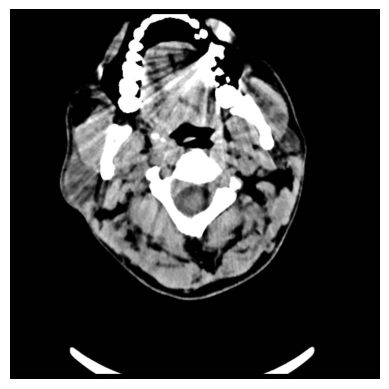

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the image in grayscale
image = cv2.imread(r'/content/drive/MyDrive/siddhi2.0/Patients_CT/049/brain/1.jpg', cv2.IMREAD_GRAYSCALE)
print(image.shape)

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

brain_model_path = r'/content/drive/MyDrive/siddhi2.0/Resnet-101-brain'
brain_model = tf.keras.models.load_model(brain_model_path)
bone_model_path = r'/content/drive/MyDrive/siddhi2.0/Resnet-101-bone'
bone_model = tf.keras.models.load_model(bone_model_path)

In [ ]:
# Print the summary to inspect the layers and their names
brain_model.summary()

# Alternatively, print the model's output layer name directly
print("Output layer name:", brain_model.layers[-1].name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 650)               1331850   
                                                                 
 dense_1 (Dense)             (None, 6)                 3906      
                                                                 
Total params: 43993932 (167.82 MB)
Trainable params: 1335756 (5.10 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Output layer name: dense_1


In [ ]:
# Print the summary to inspect the layers and their names
bone_model.summary()

# Alternatively, print the model's output layer name directly
print("Output layer name:", bone_model.layers[-1].name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 650)               1331850   
                                                                 
 dense_1 (Dense)             (None, 1)                 651       
                                                                 
Total params: 43990677 (167.81 MB)
Trainable params: 1332501 (5.08 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Output layer name: dense_1


In [ ]:
brain_model.save('/content/drive/MyDrive/siddhi2.0/Resnet-101-brain-2', save_format='tf')
bone_model.save('/content/drive/MyDrive/siddhi2.0/Resnet-101-bone-2', save_format='tf')

In [ ]:
brain_model.save('/content/drive/MyDrive/siddhi2.0/Resnet-101-brain.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
bone_model.save('/content/drive/MyDrive/siddhi2.0/Resnet-101-bone.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
